In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images


100%|██████████| 451M/451M [00:29<00:00, 15.8MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
import os

In [4]:
IMG_SIZE=130
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 3

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 15000 files belonging to 3 classes.


In [6]:
classes_name=dataset.class_names
classes_name

['Garbage Bag Images', 'Paper Bag Images', 'Plastic Bag Images']

In [7]:
#drop the last word
def delete_images(classname):
    return ''.join(classname.split()[:2])

classes_name=dataset.class_names
classes_name=list(map(delete_images,classes_name))

In [8]:
classes_name

['GarbageBag', 'PaperBag', 'PlasticBag']

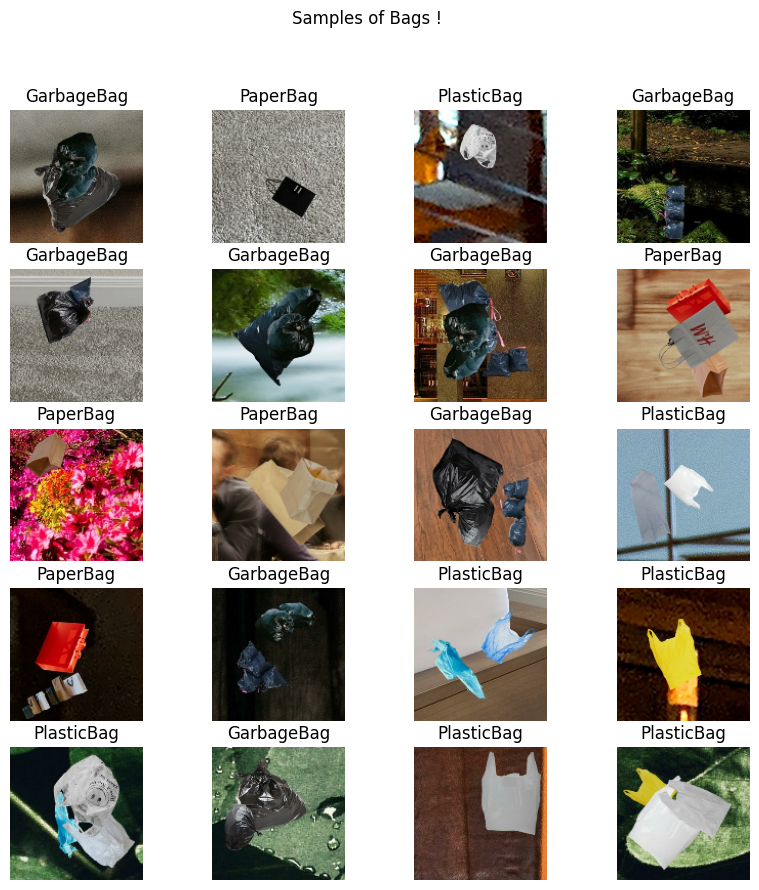

In [9]:
plt.figure(figsize=(10, 10))
plt.suptitle('Samples of Bags !')
for batch_img,batch_label in dataset.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

In [10]:
def split_train_test_val(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=1000):
   assert (train_split + test_split + val_split) == 1

   ds_size = len(dataset)

   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   test_size=int(test_split*len(dataset))
   val_size=int(val_split*len(dataset))

   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size)

   return train_ds,val_ds,test_ds

In [11]:
len(dataset)

469

In [12]:
train,val,test=split_train_test_val(dataset)

In [13]:
print('length of Training:',len(train),' batch')
print('-'*10)
print('length of Test:',len(test),' batch')
print('-'*10)
print('length of Validation:',len(val),' batch')

length of Training: 375  batch
----------
length of Test: 48  batch
----------
length of Validation: 46  batch


In [14]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [16]:
base_model = EfficientNetB3(weights='imagenet',pooling='max',include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

43941136/43941136 [==============================] - 3s 0us/step


In [17]:
model=tf.keras.models.Sequential([
    resize_and_scaling,
    base_model,
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])

In [18]:
model.build(input_shape=INPUT_SHAPE)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 130, 130, 3)         0         
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (32, 64)                  98368     
                                                                 
 dense_1 (Dense)             (32, 3)                   195       
                                                                 
Total params: 10882098 (41.51 MB)
Trainable params: 10794795 (41.18 MB)
Non-trainable params: 87303 (341.03 KB)
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [21]:
history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1)
              #  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
              #                                            patience=5,
              #                                            restore_best_weights=True)])

Epoch 1/10
375/375 [==============================] - 112s 128ms/step - loss: 0.1903 - accuracy: 0.9415 - val_loss: 1.1135 - val_accuracy: 0.3397
Epoch 2/10
375/375 [==============================] - 44s 116ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 1.1280 - val_accuracy: 0.3451
Epoch 3/10
375/375 [==============================] - 44s 117ms/step - loss: 0.0306 - accuracy: 0.9906 - val_loss: 1.2493 - val_accuracy: 0.3764
Epoch 4/10
375/375 [==============================] - 44s 117ms/step - loss: 0.0248 - accuracy: 0.9930 - val_loss: 1.9147 - val_accuracy: 0.3064
Epoch 5/10
375/375 [==============================] - 44s 117ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 1.5464 - val_accuracy: 0.3363
Epoch 6/10
375/375 [==============================] - 44s 117ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 1.7676 - val_accuracy: 0.4280
Epoch 7/10
375/375 [==============================] - 44s 117ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 2.3202 - val_a

In [22]:
model.evaluate(test_ds)

48/48 [==============================] - 3s 23ms/step - loss: 1.8909 - accuracy: 0.4583


[1.890929102897644, 0.4583333432674408]

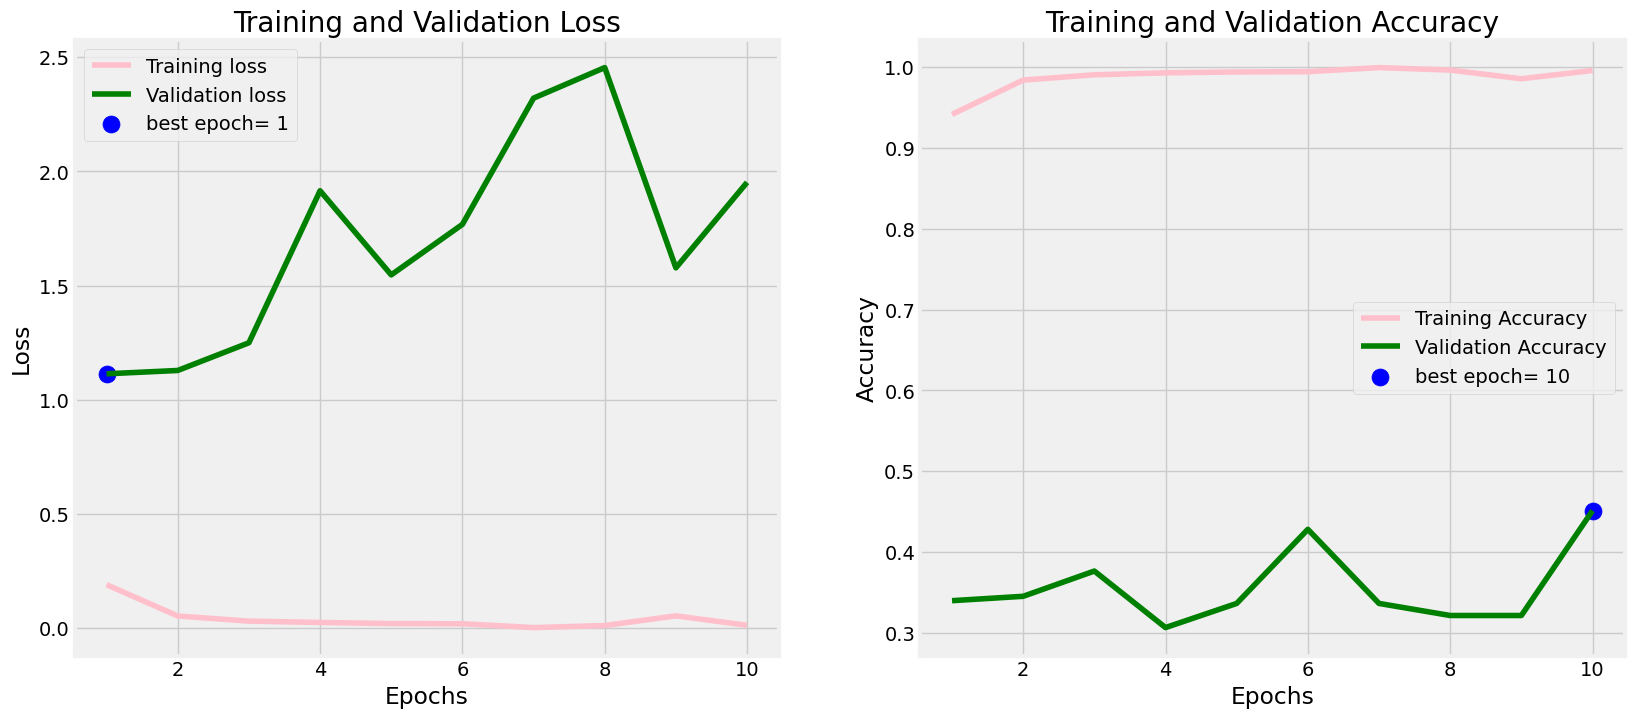

In [23]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'pink', label= 'Training loss')
plt.plot(Epochs, val_loss, 'green', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'pink', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'green', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

48/48 [==============================] - 1s 23ms/step - loss: 1.8909 - accuracy: 0.4583
Train Loss:  1.8867689371109009
Train Accuracy:  0.44954970479011536
--------------------
Validation Loss:  1.9516377449035645
Validation Accuracy:  0.45108696818351746
--------------------
Test Loss:  1.890929102897644
Test Accuracy:  0.4583333432674408


In [25]:
def get_predicitions(test_data):
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]
    classes_name=dataset.class_names

    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)

            # Convert true labels to numpy array
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Bags!')

    for i in range(31,46):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0

In [26]:
get_predicitions(test_ds)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
def display_conf_matrix():
    all_true_labels=[]
    all_predicted_labels=[]
    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Convert true labels to numpy array
        true_labels = label_batch.numpy()

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

        # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.class_names, yticklabels=dataset.class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

1/1 [==============================] - 0s 31ms/step


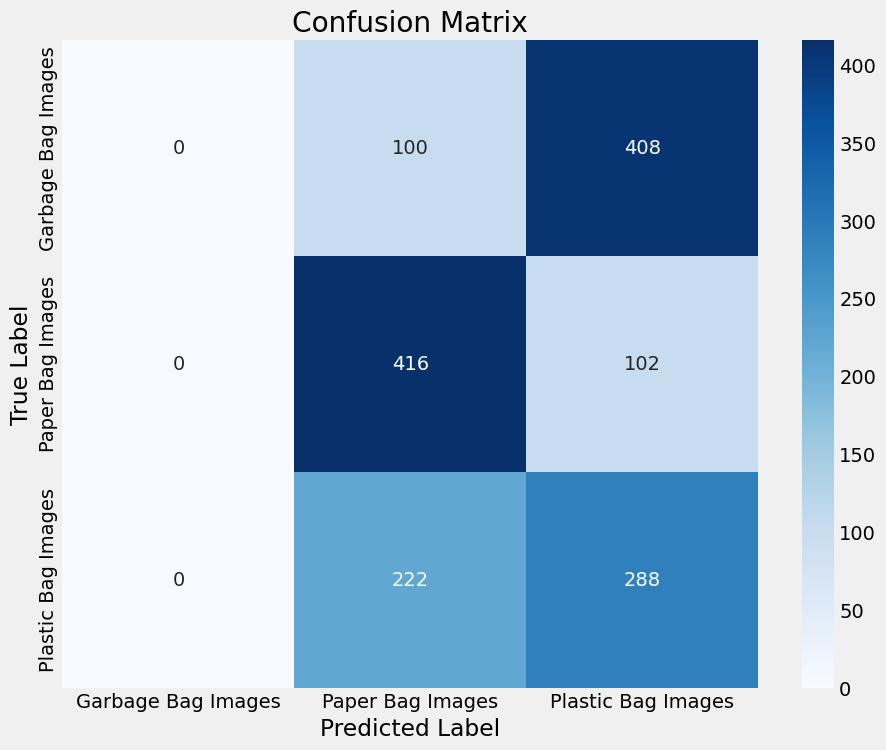

In [28]:
display_conf_matrix()